In [1]:
import os, json
from Tint_Matlab import *
import struct
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import SignalProcessing as sp
%matplotlib inline
import re
%load_ext line_profiler
import profile
import time
import mmap
import contextlib
import numpy.distutils.system_info as sysinfo

In [2]:
#bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult.bin'
# bin_filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD.bin'
#bin_filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\20170823-3-CYLINDEROPENFIELD_Mult.bin'
#bin_filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\20170823-2-CYLINDEROPENFIELD.bin'
bin_filename = "C:\\Users\\Taub Institute\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.bin"
#bin_filename = "C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\ConvFromOtherDaq\\20170829-1-CYLINDEROPENFIELD.bin"

bin_directory = os.path.dirname(bin_filename)
session = os.path.basename(os.path.splitext(bin_filename)[0])
set_filename = os.path.join(bin_directory, '%s.set' % session)
pos_filename = os.path.join(bin_directory, '%s.pos' % session)

In [3]:
def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)
    
    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)
    
    #return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)

def get_valid_pos_indices(valid_iterations):
    """This method will produce the indices of the unpacked byte data relating to the valid positions,
    as well as the the iteration (packet) number that will be later used to calculate the starting position"""
    
    num_pos_values = 9
    position_offset = 4  # number of values before the position values start

    indices = np.arange(num_pos_values)  # there are 8 position words and 1 frame count for the time
    indices = np.tile(indices, (1, len(valid_iterations)))
    indices = indices.flatten()

    offset_indices = valid_iterations*213 + position_offset
    offset_indices = np.tile(offset_indices,(num_pos_values,1))
    offset_indices = offset_indices.flatten(order='F')
    
    return indices + offset_indices


def find_n(iterations, optimal=1000):
    n = optimal
    
    while True:
        if iterations % n == 0:

            return n
        else:
            n -= 1
    return 'abort'

def get_valid_pos_bytes(valid_iterations):
    
    """This function works, but the strategy I use didn't. I was going to slice the bytearray like you would
    a numpy array but that didn't work"""
    data_byte_len = 20
    indices = np.arange(data_byte_len)
    indices = np.tile(indices, (1, len(valid_iterations)))
    indices = indices.flatten()

    offset_indices = np.arange(iterations)
    offset_indices = valid_iterations*432 + 12
    offset_indices = np.tile(offset_indices,(data_byte_len,1))
    offset_indices = offset_indices.flatten(order='F')
    
    indices = indices + offset_indices
    indices.reshape((-1, data_byte_len))
    
    return indices[:,[0,-1]]
    

In [4]:
def get_raw_pos(bin_filename):
    """This will get the raw position data from the .bin file in the following format:
    video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value

    The video timestamp is the time since the camera has been turned on, thus this value is
    irrelevent

    The .bin file is written of packets of 432 bytes containing position data, three samples of
    electrophys data (per channel), and etc.

    A packet only has a valid position if it has an "ADU2" tag in the header. You'll notice that
    the positions are sampled at twice the normal rate to avoid aliasing.
    """
    pos_sample_num = 0

    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count / bytes_per_iteration)
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)

    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)

    # Reading the Data

    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16

    byte_skip = data_byte_len + trailer_byte_len  # 384 ephys data bytes + 16 trailer bytes

    pos_Fs = 50
    n_samples = int(duration * pos_Fs)

    raw_pos = np.array([])

    with open(bin_filename, 'rb') as f:

        for i in range(iteration_count):
            byte_id = f.read(4)

            if 'ADU2' in str(byte_id):
                f.seek(8, 1)  # moves the current position by 10 bytes
                position_data = f.read(20)

                time_data = position_data[:4]
                time_data = np.asarray(struct.unpack('i', time_data))
                time_data = time_data / 50

                # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
                position_data = np.hstack((i, time_data, np.asarray(struct.unpack('8h', position_data[4:]))))

                if len(raw_pos) != 0:
                    raw_pos = np.vstack((raw_pos, position_data))
                else:
                    raw_pos = position_data

                f.seek(byte_skip, 1)

                # pos_sample_num += 1

            else:
                f.seek(bytes_per_iteration - 4, 1)
            '''
            if pos_sample_num > 50:
                break
            '''
        # the X and Y values are reverse piece-wise so lets switch the format from
        # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
        # to
        # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value

        raw_pos[:, 2:6] = raw_pos[:, [3, 2, 5, 4]]

        # find the first valid sample, since the data is ampled at 48kHz, and there are 3 samples per packet, the packet
        # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
        # will essentially take the last ADU2 headered packet values

        first_sample_index = len(np.where([raw_pos[:, 0] <= 320 - 1])[0])-1  # subtract one since indices in python start at 0

        indices = np.arange(first_sample_index, len(raw_pos)+1, 2)  # step of 2 because it needs to be downsampled
        raw_pos = raw_pos[indices, 1:]  # don't need the packet index anymore

        # if there are less than the correct number of positions, just say the rest of the time was spent at the last recorded location

        if raw_pos.shape[0] < n_samples:

            missing_n = n_samples - raw_pos.shape[0]
            last_location = raw_pos[-1, :]
            missing_samples = np.tile(last_location, (missing_n, 1))

            raw_pos = np.vstack((raw_pos, missing_samples))

    return raw_pos

In [5]:
def get_raw_posa(bin_filename):
    """This will get the raw position data from the .bin file in the following format:
    video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value

    The video timestamp is the time since the camera has been turned on, thus this value is
    irrelevent

    The .bin file is written of packets of 432 bytes containing position data, three samples of
    electrophys data (per channel), and etc.

    A packet only has a valid position if it has an "ADU2" tag in the header. You'll notice that
    the positions are sampled at twice the normal rate to avoid aliasing.
    """
    pos_sample_num = 0

    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count / bytes_per_iteration)
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)

    DaqFs = 48000
    duration = np.ceil(iteration_count * 3 / DaqFs)

    # Reading the Data

    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16

    byte_skip = data_byte_len + trailer_byte_len  # 384 ephys data bytes + 16 trailer bytes

    pos_Fs = 50
    n_samples = int(duration * pos_Fs)

    raw_pos = np.array([])

    with open(bin_filename, 'rb') as f:

        for i in range(iteration_count):
            byte_id = f.read(4)

            if 'ADU2' in str(byte_id):
                f.seek(8, 1)  # moves the current position by 10 bytes
                position_data = f.read(20)

                time_data = position_data[:4]
                time_data = np.asarray(struct.unpack('i', time_data))
                #np.ndarray((firingBlocks,), 'i', position_data[:4], 42+2, (100,))
                time_data = time_data / 50

                # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
                position_data = np.hstack((i, time_data, np.asarray(struct.unpack('8h', position_data[4:]))))

                if len(raw_pos) != 0:
                    raw_pos = np.vstack((raw_pos, position_data))
                else:
                    raw_pos = position_data

                f.seek(byte_skip, 1)

                # pos_sample_num += 1

            else:
                f.seek(bytes_per_iteration - 4, 1)
            '''
            if pos_sample_num > 50:
                break
            '''
        # the X and Y values are reverse piece-wise so lets switch the format from
        # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
        # to
        # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value

        raw_pos[:, 2:6] = raw_pos[:, [3, 2, 5, 4]]

        # find the first valid sample, since the data is ampled at 48kHz, and there are 3 samples per packet, the packet
        # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
        # will essentially take the last ADU2 headered packet values

        first_sample_index = len(np.where([raw_pos[:, 0] <= 320 - 1])[0])-1  # subtract one since indices in python start at 0

        indices = np.arange(first_sample_index, len(raw_pos)+1, 2)  # step of 2 because it needs to be downsampled
        raw_pos = raw_pos[indices, 1:]  # don't need the packet index anymore

        # if there are less than the correct number of positions, just say the rest of the time was spent at the last recorded location

        if raw_pos.shape[0] < n_samples:

            missing_n = n_samples - raw_pos.shape[0]
            last_location = raw_pos[-1, :]
            missing_samples = np.tile(last_location, (missing_n, 1))

            raw_pos = np.vstack((raw_pos, missing_samples))

    return raw_pos

In [74]:
data = get_raw_pos2(filename)

In [75]:
num_iterations = int(len(data)/432)
print(len(data))
byte_ids = np.ndarray((num_iterations,), 'S4', data, 0, 432)
pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes
valid_byte_numbers = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

time_stamp = np.ndarray((num_iterations,), np.uint32, data, 12, 432)[pos_bool]
positions = np.ndarray((num_iterations,), (np.uint16, (1,8)), data, 16, (432,)).reshape((-1,8))[pos_bool, :]

print(time_stamp)

355475520
[314573 317749 317750 ..., 320319 320320 320320]


In [48]:
data[:100]
12441643200/355475520

35.0

In [36]:
%%time

import mmap
import contextlib
filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\Raw30Min\\20170927-RAW-30MIN.bin'
# filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\Raw30m\\20170927-RAW-30MIN.bin'
#filename = bin_filename

with open(filename, 'rb') as f:
    # pass
    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
        num_iterations = int(len(m)/432)
        byte_ids = np.ndarray((num_iterations,), 'S4', m, 0, 432)
        pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes
        valid_byte_numbers = np.arange(len(byte_ids))[pos_bool]  # getting the packet number
        

        time_stamp = np.ndarray((num_iterations,), np.uint32, m, 12, 432)[pos_bool]
        print(time_stamp)
        
        positions = np.ndarray((num_iterations,), (np.uint16, (1,8)), m, 16, (432,)).reshape((-1,8))[pos_bool][:]
  
        #print(positions)
        
#positions.setflags(write=1)
positions[:, 0:4] = positions[:, [1, 0, 3, 2]]
# positions[:, 0:4] = 1
#print(positions)
print(positions)

[314573 317749 317750 ..., 407750 407750 407751]
[[ 102  148 1023 ...,   65    0   65]
 [  76   96 1023 ...,  112    0  112]
 [  92  117 1023 ...,   84    0   84]
 ..., 
 [  62  108 1023 ...,   97    0   97]
 [  62  108 1023 ...,   97    0   97]
 [  50   84 1023 ...,  117    0  117]]
Wall time: 3.05 s


In [45]:
positions[180000:][:]

array([[  62,  108, 1023, 1023,    0,   97,    0,   97],
       [  50,   84, 1023, 1023,    0,  117,    0,  117]], dtype=uint16)

In [41]:
first_sample_index = len(np.where(valid_byte_numbers <= 320 - 1)[0])-1
print(first_sample_index)
indices = np.arange(first_sample_index, len(positions)+1, 2)  # step of 2 because it needs to be downsampled
print(indices, len(positions))
if indices[-1] >= len(positions):
    indices = indices[:-1]
    
print(positions[indices,:])

2
[     2      4      6 ..., 179998 180000 180002] 180002
[[  92  117 1023 ...,   84    0   84]
 [  76   94 1023 ...,  104    0  104]
 [  94  117 1023 ...,   84    0   84]
 ..., 
 [  52   89 1023 ...,  118    0  118]
 [  72  122 1023 ...,   78    0   78]
 [  62  108 1023 ...,   97    0   97]]


In [7]:
314573 / 50

6291.46

In [32]:
%%time

import mmap
import contextlib
filename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\Raw30Min\\20170927-RAW-30MIN.bin'
# filename = 'C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\Raw30m\\20170927-RAW-30MIN.bin'
#filename = bin_filename

with open(filename, 'rb') as f:
    # pass
    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
        num_iterations = int(len(m)/432)
        byte_ids = np.ndarray((num_iterations,), 'S4', m, 0, 432)
        pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes
        valid_byte_numbers = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

        time_stamp = np.ndarray((num_iterations,), np.uint32, m, 12, 432)[pos_bool]
        positions = np.ndarray((num_iterations,), (np.uint16, (1,8)), m, 16, (432,)).reshape((-1,8))[pos_bool][:]

#positions.setflags(write=1) 
positions[:, 0:4] = positions[:, [1, 0, 3, 2]]
# positions[:, 0:4] = 1
print(positions)

print(np.divide(time_stamp, 50))

[[[  96   76 1023 ...,  112    0  112]
  [ 148  102 1023 ...,   65    0   65]
  [ 117   92 1023 ...,   84    0   84]
  ..., 
  [ 108   62 1023 ...,   97    0   97]
  [ 108   62 1023 ...,   97    0   97]
  [  84   50 1023 ...,  117    0  117]]]
[ 1048.58  1112.1   1112.12 ...,   290.68   290.68   290.7 ]
Wall time: 3.73 s


In [156]:
%%time

data = get_raw_pos2a(filename, mode='mmap')
print(data)

[[ 6355.      92.     117.   ...,    84.       0.      84.  ]
 [ 6355.    1023.    1023.   ...,    84.       0.      84.  ]
 [ 6355.02    76.      94.   ...,   104.       0.     104.  ]
 ..., 
 [ 8155.02  1023.    1023.   ...,   117.       0.     117.  ]
 [ 8155.02    50.      84.   ...,   117.       0.     117.  ]
 [ 8155.02  1023.    1023.   ...,   117.       0.     117.  ]]
Wall time: 2.88 s


In [157]:
data.shape

(180100, 9)

In [154]:
data = get_raw_pos2a(filename, mode='non')
print(data)

[[ 6355.      92.     117.   ...,    84.       0.      84.  ]
 [ 6355.    1023.    1023.   ...,    84.       0.      84.  ]
 [ 6355.02    76.      94.   ...,   104.       0.     104.  ]
 ..., 
 [ 8155.02  1023.    1023.   ...,   117.       0.     117.  ]
 [ 8155.02    50.      84.   ...,   117.       0.     117.  ]
 [ 8155.02  1023.    1023.   ...,   117.       0.     117.  ]]


In [77]:
posfilename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\Raw30Min - Copy\\20170927-RAW-30MIN_converted.pos'
#posfilename = 'C:\\Users\\Taub Institute\\Desktop\\RAW Data\\ConvFromOtherDaq - Copy\\20170829-1-CYLINDEROPENFIELD_converted.pos'
posx, posy, post = getpos(posfilename, 'BehaviorRoom', method='raw')
print(np.hstack((post, posx, posy)))

[[  3.17750000e+05   9.20000000e+01   1.17000000e+02]
 [  3.17751000e+05   7.60000000e+01   9.40000000e+01]
 [  3.17752000e+05   9.40000000e+01   1.17000000e+02]
 ..., 
 [  4.07751000e+05   5.00000000e+01   8.40000000e+01]
 [  4.07751000e+05   5.00000000e+01   8.40000000e+01]
 [  4.07751000e+05   5.00000000e+01   8.40000000e+01]]


In [54]:
52429/50

1048.58

In [25]:
def get_raw_pos2(bin_filename):
    """This will get the raw position data from the .bin file in the following format:
    video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
    
    The video timestamp is the time since the camera has been turned on, thus this value is
    irrelevent
    
    The .bin file is written of packets of 432 bytes containing position data, three samples of 
    electrophys data (per channel), and etc.
    
    A packet only has a valid position if it has an "ADU2" tag in the header. You'll notice that
    the positions are sampled at twice the normal rate to avoid aliasing.
    """
    pos_sample_num = 0
    
    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count/bytes_per_iteration)  
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
    
    optimal_iteration = 1000000
    if optimal_iteration >= iteration_count:
        simul_iterations = iteration_count
    else:
        simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

    n = int(iteration_count / simul_iterations) # finds how many loops to do
    byte_chunksize = int(simul_iterations * bytes_per_iteration)
    
    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)
    
    pos_Fs = 50
    n_samples = int(duration * pos_Fs)
    
    #Reading the Data
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    raw_pos = np.array([])
    
    #iteration_string = '%dh' % (8)
    iteration_string = '%di%dhi%dh' % (2, 2, 8+192+1+1+5+1) 
    
    pos_data = b''
    
    positions = np.array([])
    
    with open(bin_filename, 'rb') as f:
        
        iteration_start = 0
        
        for i in range(n):
            data = f.read(byte_chunksize)
            
            return data
             # find the indices of ADU2, ADU2 is where the position is valid
            valid_iterations = (np.asarray([instance.start() for instance in re.finditer(b'ADU2', data)])/432).astype(int)
            
            # return data
            data = np.asarray(struct.unpack('<%s' % (simul_iterations*iteration_string), data))
            
            # get the indices that the positions are in                              
            pos_indices = get_valid_pos_indices(valid_iterations)
            
            i = valid_iterations + iteration_start
            
            data = data[pos_indices].reshape((-1, 9))  # There are 8 values for positions and 1 for the frame count (timestamp)
            
            data = np.hstack((i.reshape((-1,1)), data))
            
            iteration_start += simul_iterations
            
            if len(positions) != 0:
                
                positions = np.vstack((positions, data))
                
            else:
                
                positions = data
        
        positions[:,1] = positions[:,1] / 50  # converting from a frame count to a time value in seconds
        
        # positions is structured as: packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value 

        # the X and Y values are reverse piece-wise so lets switch the format from 
        # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
        # to 
        # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
        
        positions[:, 2:6] = positions[:, [3, 2, 5, 4]] 
        
        # find the first valid sample, since the data is sampled at 48kHz, and there are 3 samples per packet, the packet
        # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
        # will essentially take the last ADU2 headered packet values
        
        first_sample_index = len(np.where(positions[:, 0] <= 320 - 1)[0])-1  # subtract one since indices in python start at 0

        indices = np.arange(first_sample_index, len(positions)+1, 2)  # step of 2 because it needs to be downsampled
        positions = positions[indices, 1:]  # don't need the packet index anymore

        # if there are less than the correct number of positions, just say the rest of the time was spent at the last recorded location

        if positions.shape[0] < n_samples:

            missing_n = int(2*n_samples - positions.shape[0])
            last_location = positions[-1, :]
            missing_samples = np.tile(last_location, (missing_n, 1))

            positions = np.vstack((positions, missing_samples))
    
    return positions


In [149]:
def get_raw_pos2a(bin_filename, mode='mmap'):
    """This will get the raw position data from the .bin file in the following format:
    video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
    
    The video timestamp is the time since the camera has been turned on, thus this value is
    irrelevent
    
    The .bin file is written of packets of 432 bytes containing position data, three samples of 
    electrophys data (per channel), and etc.
    
    A packet only has a valid position if it has an "ADU2" tag in the header. You'll notice that
    the positions are sampled at twice the normal rate to avoid aliasing.
    
    There are two modes, one will use memory mapping, and the other will not: 'mmap' or 'non'
    """
    pos_sample_num = 0
    
    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count/bytes_per_iteration)  
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
    
    optimal_iteration = 1000000
    if optimal_iteration >= iteration_count:
        simul_iterations = iteration_count
    else:
        simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

    n = int(iteration_count / simul_iterations) # finds how many loops to do
    byte_chunksize = int(simul_iterations * bytes_per_iteration)

    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)
    
    pos_Fs = 50
    n_samples = int(duration * pos_Fs)
    
    #Reading the Data
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    raw_pos = np.array([]).astype(float)
    
    if sysinfo.platform_bits != 64:
        mode = 'non'  # do not mmap with a 32 bit python
    
    with open(bin_filename, 'rb') as f:
        
        if mode == 'mmap':
            # we will use memory mapped objects
            
            with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
                num_iterations = int(len(m)/bytes_per_iteration)
                
                byte_ids = np.ndarray((num_iterations,), 'S4', m, 0, 432)
                
                pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes
                
                valid_iterations = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

                time_stamp = np.ndarray((num_iterations,), np.uint32, m, 12, 432)[pos_bool].reshape((-1,1))  # gettinge the time stamp data
                
                raw_pos = np.ndarray((num_iterations,), (np.uint16, (1,8)), m, 16, (432,)).reshape((-1,8))[pos_bool][:]
             
                raw_pos = np.hstack((valid_iterations.reshape((-1,1)), time_stamp, raw_pos)).astype(float)  # stacking all these values to create one matrix

        else:
            
            # in some cases using memory mapping will be slow, such as using 32 bit python
            
            iteration_start = 0
            # we will iterate
            for i in range(n):
                data = f.read(byte_chunksize)
                num_iterations = int(len(data)/bytes_per_iteration)

                byte_ids = np.ndarray((num_iterations,), 'S4', data, 0, 432)

                pos_bool = np.where(byte_ids == b'ADU2')  # valid position packets have an ADU2 header b'ADU2' in bytes

                valid_iterations = np.arange(len(byte_ids))[pos_bool]  # getting the packet number

                time_stamp = np.ndarray((num_iterations,), np.uint32, data, 12, 432)[pos_bool].reshape((-1,1))  # gettinge the time stamp data
                
                positions = np.ndarray((num_iterations,), (np.uint16, (1,8)), data, 16, (432,)).reshape((-1,8))[pos_bool][:]
                
                i = np.add(valid_iterations, iteration_start)  # offsetting the samples depending on the chunk number (n)

                positions = np.hstack((i.reshape((-1,1)), time_stamp, positions)).astype(float)  # stacking all these values to create one matrix
                
                iteration_start += simul_iterations

                if len(raw_pos) != 0:

                    raw_pos = np.vstack((raw_pos, positions))

                else:

                    raw_pos = positions

        
        raw_pos[:,1] = np.divide(raw_pos[:,1], 50)  # converting from a frame count to a time value in seconds
        
        # raw_pos is structured as: packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value 

        # the X and Y values are reverse piece-wise so lets switch the format from 
        # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
        # to 
        # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
        
        raw_pos[:, 2:6] = raw_pos[:, [3, 2, 5, 4]] 
        
         # find the first valid sample, since the data is sampled at 48kHz, and there are 3 samples per packet, the packet
        # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
        # will essentially take the last ADU2 headered packet values
        
        first_sample_index = len(np.where(raw_pos[:, 0] <= 320 - 1)[0])-1  # subtract one since indices in python start at 0
        
        raw_pos = raw_pos[first_sample_index:,:]
        
        # there should be twice the number of samples since they double sampled to stop aliasing
        # if there is not 2 * n_samples, append the last recorded sample to the end (we will assume the animal remained there
        # for the rest of the time) 

        if raw_pos.shape[0] < 2*n_samples:

            missing_n = int(2*n_samples - raw_pos.shape[0])
            last_location = raw_pos[-1, :]
            missing_samples = np.tile(last_location, (missing_n, 1))

            raw_pos = np.vstack((raw_pos, missing_samples))
        
        # now we will set the oversampled data to 1023 (NaN) as that is how the converter treats the double sampled data
        
        indices = np.arange(1,raw_pos.shape[0], 2)
        if indices[-1] >= raw_pos.shape[0]:
            indices = indices[:-1]
        
        raw_pos[indices, 2:4] = 1023
        
        raw_pos = raw_pos[:, 1:]  # don't need the packet index anymore
    
    return raw_pos


In [55]:
a = np.array([1,3,4,55,56,6,8])
print(a[np.arange(1,len(a), 2)])

[ 3 55  6]


In [ ]:
%lprun -f get_raw_pos2a get_raw_pos2a(bin_filename)

In [296]:
data = get_raw_pos2a(bin_filename)
# data = get_raw_pos2a('C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\Raw30m\\20170927-RAW-30MIN.bin')
plt.plot(data[:,1], data[:,2])

AttributeError: 'bytes' object has no attribute 'ravel'

In [291]:
%timeit data = get_raw_pos2a('C:\\Users\\Geoffrey Barrett\\Desktop\\RAW Data\\Raw30m\\20170927-RAW-30MIN.bin')

355475520
355475520
355475520
355475520
1 loop, best of 3: 1min 44s per loop


In [275]:
%timeit data = get_raw_pos2a(bin_filename)
%timeit data = get_raw_pos(bin_filename)

1 loop, best of 3: 349 ms per loop
1 loop, best of 3: 2.13 s per loop


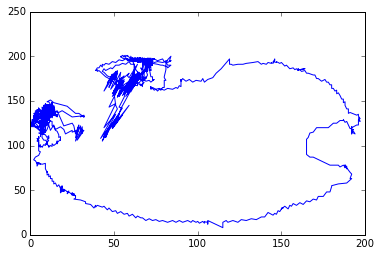

In [268]:
data = get_raw_pos2(bin_filename)
plt.plot(data[:,1], data[:,2])

In [233]:
%timeit data = get_raw_pos2(bin_filename)
%timeit data = get_raw_pos2a(bin_filename)

1 loop, best of 3: 32.8 s per loop


ValueError: all the input arrays must have same number of dimensions

In [8]:
def get_raw_pos3(bin_filename):
    """This will get the raw position data from the .bin file in the following format:
    video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
    
    The video timestamp is the time since the camera has been turned on, thus this value is
    irrelevent
    
    The .bin file is written of packets of 432 bytes containing position data, three samples of 
    electrophys data (per channel), and etc.
    
    A packet only has a valid position if it has an "ADU2" tag in the header. You'll notice that
    the positions are sampled at twice the normal rate to avoid aliasing.
    """
    pos_sample_num = 0
    
    byte_count = os.path.getsize(bin_filename)
    bytes_per_iteration = 432
    iteration_count = int(byte_count/bytes_per_iteration)  
    sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)
    
    optimal_iteration = 1000000
    if optimal_iteration >= iteration_count:
        simul_iterations = iteration_count
    else:
        simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

    n = int(iteration_count / simul_iterations) # finds how many loops to do
    byte_chunksize = int(simul_iterations * bytes_per_iteration)
    
    DaqFs = 48000
    duration = iteration_count * 3 / DaqFs
    duration = np.ceil(duration)
    
    pos_Fs = 50
    n_samples = int(duration * pos_Fs)
    
    #Reading the Data
    
    header_byte_len = 32
    data_byte_len = 384
    trailer_byte_len = 16
    
    raw_pos = np.array([])
    
    #iteration_string = '%dh' % (8)
    iteration_string = '%di%dhi%dh' % (2, 2, 8+192+1+1+5+1) 
    
    pos_data = b''
    
    positions = np.array([])
    
    with open(bin_filename, 'rb') as f:
        
        iteration_start = 0
        
        for i in range(n):
            data = f.read(byte_chunksize)
            
             # find the indices of ADU2, ADU2 is where the position is valid
            valid_iterations = (np.asarray([instance.start() for instance in re.finditer(b'ADU2', data)])/432).astype(int)
            
            # return data
            data = np.asarray(struct.unpack('<%s' % (simul_iterations*iteration_string), data))
            
            # get the indices that the positions are in                              
            pos_indices = get_valid_pos_indices(valid_iterations)
            
            i = valid_iterations + iteration_start
            
            data = data[pos_indices].reshape((-1, 9))  # There are 8 values for positions and 1 for the frame count (timestamp)
            
            data = np.hstack((i.reshape((-1,1)), data))
            
            iteration_start += simul_iterations
            
            if len(positions) != 0:
                
                positions = np.vstack((positions, data))
                
            else:
                
                positions = data
        
        positions[:,1] = positions[:,1] / 50  # converting from a frame count to a time value in seconds
        
        # positions is structured as: packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value 

        # the X and Y values are reverse piece-wise so lets switch the format from 
        # packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
        # to 
        # packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value
        
        positions[:, 2:6] = positions[:, [3, 2, 5, 4]] 
        
        # find the first valid sample, since the data is sampled at 48kHz, and there are 3 samples per packet, the packet
        # rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
        # will essentially take the last ADU2 headered packet values
        
        first_sample_index = len(np.where([positions[:, 0] <= 320 - 1])[0])-1  # subtract one since indices in python start at 0

        indices = np.arange(first_sample_index, len(positions)+1, 2)  # step of 2 because it needs to be downsampled
        positions = positions[indices, 1:]  # don't need the packet index anymore

        # if there are less than the correct number of positions, just say the rest of the time was spent at the last recorded location

        if positions.shape[0] < n_samples:

            missing_n = n_samples - positions.shape[0]
            last_location = positions[-1, :]
            missing_samples = np.tile(last_location, (missing_n, 1))

            positions = np.vstack((positions, missing_samples))
    
    return positions


In [57]:
data = get_raw_pos2(bin_filename)
print(data[:100])

b'ADU1\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


In [56]:
plt.plot(data[:,1], data[:,2])

TypeError: byte indices must be integers, not tuple

In [19]:
print(p.print_stats())

         6102 function calls in 32.265 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       11   22.381    2.035   22.381    2.035 {built-in method array}
        1    6.909    6.909    6.909    6.909 {built-in method unpack}
        1    2.396    2.396   32.265   32.265 <ipython-input-5-c839f6a7c4aa>:30(get_raw_pos2)
        1    0.320    0.320    0.320    0.320 {method 'read' of '_io.BufferedReader' objects}
        1    0.251    0.251    0.253    0.253 <ipython-input-5-c839f6a7c4aa>:89(<listcomp>)
     6001    0.002    0.000    0.002    0.000 {method 'start' of '_sre.SRE_Match' objects}
        1    0.001    0.001    0.004    0.004 <ipython-input-5-c839f6a7c4aa>:1(get_valid_pos_indices)
        3    0.001    0.000    0.001    0.000 {method 'repeat' of 'numpy.ndarray' objects}
        3    0.001    0.000    0.002    0.001 shape_base.py:785(tile)
        2    0.001    0.000    0.001    0.000 {method 'flatten' of 'numpy.n

In [35]:
pr = profile.Profile()
res = pr.run("get_raw_pos2(bin_filename)")
res.print_stats()

         6103 function calls in 23.031 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.000    0.000 :0(all)
        4    0.000    0.000    0.000    0.000 :0(append)
        2    0.000    0.000    0.000    0.000 :0(arange)
       11   16.344    1.486   16.344    1.486 :0(array)
        1    0.000    0.000    0.000    0.000 :0(astype)
        2    0.000    0.000    0.000    0.000 :0(concatenate)
        1    0.000    0.000   23.031   23.031 :0(exec)
        1    0.000    0.000    0.000    0.000 :0(finditer)
        2    0.000    0.000    0.000    0.000 :0(flatten)
       17    0.000    0.000    0.000    0.000 :0(len)
        1    0.000    0.000    0.000    0.000 :0(open)
        1    0.234    0.234    0.234    0.234 :0(read)
        3    0.000    0.000    0.000    0.000 :0(repeat)
        8    0.000    0.000    0.000    0.000 :0(reshape)
        1    0.000    0.000    0.000    0.000 :0(setprof

In [58]:
# find the indices of ADU2, ADU2 is where the position is valid
import re
valid_iterations = (np.asarray([instance.start() for instance in re.finditer(b'ADU2', data)])/432).astype(int)
print(valid_iterations)
print(max(valid_iterations))

[     1    152    312 ..., 959672 959832 959992]
959992


In [292]:
%lprun -f get_raw_pos2a get_raw_pos2a(bin_filename)

414763200
